# Deep Portfolio Theory - analyze the ability of a Neural Network based approach to uncover market factors
### Data
Synthetic data and S&P 500 daily returns data.

###  Objective
Compare PCA and Neural Networks in their ability to uncover market factors, and apply to portfolio construction.

1. Generate synthetic stock return data with one market factor and autoregressive residuals. Then use PCA the uncover and estimate mean reversion and volatility of residuals.
2. Try to uncover the factors and the residuals using the Deep Learning approach.
3. Do the analysis with the S&P 500 data. You may want to add technical indicators as additional predictors.

### Literatures
1. J. Yeo and G. Papanicolaou, “Random Matrix Approach to Estimation of High-Dimensional Factor Models” (2016) (https://arxiv.org/pdf/1611.05571.pdf)
2. J. Heaton, N. Polson, J. Witte, “Deep Portfolio Theory”
https://arxiv.org/abs/1605.07230
3. N. Polson and V. Sokolov, “Deep Learning: a Bayesian Perspective” (2017) https://arxiv.org/abs/1706.00473
4. L.Troiano, E. Mejuto, and P. Kriplani, “On Feature Reduction using Deep Learning for Trend Prediction in Finance” (2016) https://arxiv.org/abs/1704.03205


In [10]:
import numpy as np
np.warnings.filterwarnings("ignore")

import pandas as pd
import scipy
from datetime import datetime
import time
import pytz
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.layers import core as core_layers

import pandas_datareader.data as web
import talib
from talib import MA_Type

from numpy.random import seed
from scipy.stats import norm
import scipy.stats as stats
from scipy.linalg import sqrtm

from sklearn import datasets,metrics, linear_model, svm
from sklearn import preprocessing as prep
from sklearn.decomposition import PCA
import statsmodels.api as sm

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
warnings.filterwarnings(action="ignore", module="pandas")

# utility function to reset the TF graph to the same state each time
def reset_graph():
    tf.reset_default_graph()
    tf.set_random_seed(42)
    np.random.seed(42)

## 1.1 Generating synthetic data.

J.Yeo adn G. Papanicolaou's model of generating synthetic data:
$$R = LF + U$$
R = synthetic return (N $\times$ T)

L = factor loading (N $\times$ p)

F = Factor (p $\times$ T)

U = synthetic residuals (N $\times$ T)

$U = A_N^{1/2}\epsilon B_T^{1/2}$

$A_N = \{ (A_N)_{ii} = 1,(A_N)_{ij, i\neq j} = \beta \}$

$B_T = \{ (B_T)_{st} = exp(-|s-t|/\tau)\}$

We first create a class to generate synthetic data.

In [2]:
class syn_data:
    def __init__(self, b, p, N, T):
        A = np.eye(N)
        B = np.ones((T,T))
        noise = np.random.normal(size = (N,T))
        for s in range(T):
            for t in range(T):
                B[s][t] = b ** (np.abs(s-t))
        U = A.dot(noise).dot(sqrtm(B))
        self.U = U
        self.factor = np.random.normal(size=(p, T))
        self.factor_loading = np.random.normal(size=(N,p))/p
        
        self.ret = np.dot(self.factor_loading, self.factor) + U

In [3]:
# Set parameter for the data set. Number of feature is 1, N = T = 50.
p = 1
N = 50
T = 50

In [4]:
def linear_regression(data):
    ret = data.ret
    factor = data.factor
    # add_bias
    factor_b = np.concatenate((factor, np.ones(T).reshape(1,-1)),axis=0)
    
    regr = linear_model.LinearRegression()
    regr.fit(factor_b.T, ret.T)
    coef = regr.coef_[:,0].reshape(-1,1)
    ret_1 = np.dot(coef, factor)
    U = ret - ret_1
    
    b_estimate = []
    corr = pd.DataFrame(U).corr()
    for t in range(T-1):
        b_estimate.append(corr[t+1][t])
    return np.mean(b_estimate)


In [5]:
def PCA(data):
    ret = data.ret
    factor_loading = data.factor_loading.reshape(-1,1)
    
    eig = np.linalg.eig(np.cov(ret))
    eig_value = eig[0]
    idx = np.argsort(eig_value)[::-1][:p]
    eig_value = eig[0][idx]
    eig_vector = eig[1][idx]
    
    X = eig_vector.dot(ret)
    U = ret - factor_loading.dot(X)
    
    b_estimate = []
    corr = pd.DataFrame(U).corr()
    for t in range(T-1):
        b_estimate.append(corr[t+1][t])
    return np.mean(b_estimate)

In [6]:
class AutoEncoder_layer1:
    def __init__(self, n_input = N, num_hidden=5, activation_function=tf.nn.relu, learning_rate = 0.01, optimizer = tf.train.GradientDescentOptimizer):
        self.X = tf.placeholder("float", [None, n_input])
        self.Y = tf.placeholder("float", [None, 1])
        
        self.activation = activation_function
        self.weight_encoder = tf.Variable(tf.random_normal([n_input, num_hidden]))
        self.weight_decoder = tf.Variable(tf.random_normal([num_hidden, n_input]))
        self.bias_encoder = tf.Variable(tf.random_normal([num_hidden]))
        self.bias_decoder = tf.Variable(tf.random_normal([n_input]))
        
        encoder_op = self.encoder()
        decoder_op = self.decoder(encoder_op)
        self.x_predict=decoder_op
        self.x_true = self.X
        
        # Define loss and optimizer, minimize the squared error
        self.loss = tf.reduce_mean(tf.square(decoder_op - self.X))
        self.optimizer =  optimizer(learning_rate).minimize(self.loss)
        self.U = self.X - self.x_predict
    
    def encoder(self):
        layer = self.activation(tf.add(tf.matmul(self.X, self.weight_encoder),self.bias_encoder))
        return layer
    
    def decoder(self,Y):
        layer = self.activation(tf.add(tf.matmul(Y, self.weight_decoder),self.bias_decoder))
        return layer

In [7]:
def NN(data):
    X = data.ret.reshape((N,T))
    model = AutoEncoder_layer1()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(1000):
            _=sess.run(model.optimizer, feed_dict={model.X: X})
            
        U = sess.run(model.U, feed_dict={model.X: X})
    b_estimate = []
    corr = pd.DataFrame(U).corr()
    for t in range(T-1):
        b_estimate.append(corr[t+1][t])
    b = np.mean(b_estimate)
    return b

In [8]:
reset_graph()
starttime = time.time()

b_lr = []
b_pca = []
b_NN = []

# setting b value (0,1), step = 0.01
b_set = np.linspace(0,0.99,100)

for b in b_set:
    # generating data with b
    data = syn_data(b, p, N, T)
    
    b_lr.append(linear_regression(data))
    b_pca.append(PCA(data))
    b_NN.append(NN(data))

endtime = time.time()
print('Computational time:', endtime - starttime, 'seconds')

Computational time: 230.44047808647156 seconds


In [13]:
error_lr = np.average((b_set-b_lr)**2)
print("Error with Linear Regression is " + str(error_lr) + ".")
error_pca = np.average((b_set-b_pca)**2)
print("Error with PCA is " + str(error_pca)+ ".")
error_nn = np.average((b_set-b_NN)**2)
print("Error with Neural Network is " + str(error_nn)+ ".")

Error with Linear Regression is 0.00035427665666428555.
Error with PCA is 0.06311390858042264.
Error with Neural Network is 0.06070906511195742.


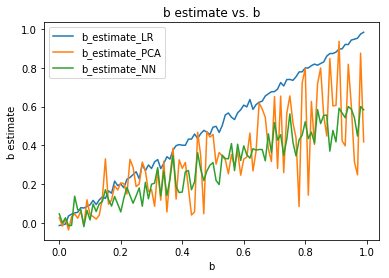

In [14]:
# plot b_estimate by 3 approaches
plt.plot(b_set, b_lr, label='b_estimate_LR')
plt.plot(b_set, b_pca, label='b_estimate_PCA')
plt.plot(b_set, b_NN, label='b_estimate_NN')
plt.legend()
plt.xlabel("b")
plt.ylabel("b estimate")
plt.title("b estimate vs. b")
plt.show()

In [15]:
reset_graph()
# plot loss in NN approach
data = syn_data(0.5,p,N,T)
X = data.ret.reshape((N,T))
model = AutoEncoder_layer1()
train_steps = []
losses = []
    
# Define loss and optimizer, minimize the squared error
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        _=sess.run(model.optimizer, feed_dict={model.X: X})
        if i%10 == 0:
            train_steps.append(i)
            loss = sess.run(model.loss, feed_dict={model.X: X})
            losses.append(loss)

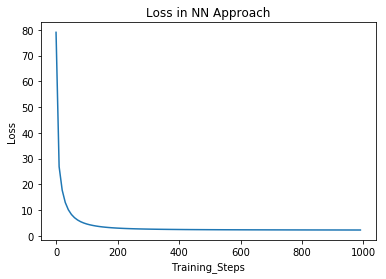

In [16]:
plt.plot(train_steps,losses)
plt.xlabel("Training_Steps")
plt.ylabel("Loss")
plt.title("Loss in NN Approach")
plt.show()

## Uncover factors with Auto-Encoder
Now we try to uncover 50 factors using Auto-Encoder and use these extracted features to make prediction using auto-encoder.

Architecturally, the simplest form of an autoencoder is a feedforward, non-recurrent neural network very similar to the multilayer perceptron (MLP) – having an input layer, an output layer and one or more hidden layers connecting them – but with the output layer having the same number of nodes as the input layer, and with the purpose of reconstructing its own inputs (instead of predicting the target value $Y$ given inputs $X$. Therefore, autoencoders are unsupervised learning models.

For better understanding the structure of AutoEncoder, this time we set the number of hidden layers = 2( [20, 10] ), activation function is sigmoid, the optimizer is AdamOptimizer, loss is definded as minimum squared error.

Here we have p = 50, N = T = 50, then we reconstruct its own input and get the graph conparing the original data and the reconstructed data(output). The result is actually quite a satisfaction.


In [17]:
class AutoEncoder_layer2:
    def __init__(self, n_input, num_hidden=[20,10], activation_function=tf.nn.sigmoid, learning_rate = 0.01, optimizer = tf.train.AdamOptimizer, error="MSE"):
        self.X = tf.placeholder("float", [None, n_input])
        self.Y = tf.placeholder("float", [None, 1])
        
        self.activation = activation_function
        num_hidden_1, num_hidden_2 = num_hidden
        self.weight_encoder_1 = tf.Variable(tf.random_normal([n_input, num_hidden_1]))
        self.weight_encoder_2 = tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2]))
        self.weight_decoder_1 = tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1]))
        self.weight_decoder_2 = tf.Variable(tf.random_normal([num_hidden_1, n_input]))
        self.bias_encoder_1 = tf.Variable(tf.random_normal([num_hidden_1]))
        self.bias_encoder_2 = tf.Variable(tf.random_normal([num_hidden_2]))
        self.bias_decoder_1 = tf.Variable(tf.random_normal([num_hidden_1]))
        self.bias_decoder_2 = tf.Variable(tf.random_normal([n_input]))
        
        encoder_op = self.encoder()
        decoder_op = self.decoder(encoder_op)
        self.x_predict = decoder_op
        self.x_true = self.X
        
        # Define loss and optimizer, minimize the squared error
        if error == "MSE":
            self.loss = tf.reduce_mean(tf.square(decoder_op - self.X))
        else:
            self.loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=decoder_op,labels=self.X))
        
        self.optimizer = optimizer(learning_rate).minimize(self.loss)
        self.U = self.X - self.x_predict
    
    def encoder(self):
        layer_1 = self.activation(tf.add(tf.matmul(self.X, self.weight_encoder_1),self.bias_encoder_1))
        layer_2 = self.activation(tf.add(tf.matmul(self.weight_encoder_1, self.weight_encoder_2),self.bias_encoder_2))
        return layer_2

    def decoder(self,Y):
        layer_1 = self.activation(tf.add(tf.matmul(Y, self.weight_decoder_1),self.bias_decoder_1))
        layer_2 = tf.add(tf.matmul(layer_1, self.weight_decoder_2),self.bias_decoder_2)
        return layer_2

In [18]:
reset_graph()
N = 50
T = 50
p = 50
b = 0
data = syn_data(b, p, N, T)
ret = data.ret
R = ret.reshape((N*T))
X = ret.reshape((N,T))
AEmodel = AutoEncoder_layer2(n_input=N, error="MSE")
U_origin = data.U
losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        _=sess.run(AEmodel.optimizer, feed_dict={AEmodel.X: X})
        loss=sess.run(AEmodel.loss, feed_dict={AEmodel.X: X})
        losses.append(loss)
        R_predict= sess.run(AEmodel.x_predict, feed_dict={AEmodel.X: X})
R_MSE = R_predict.reshape((N*T))

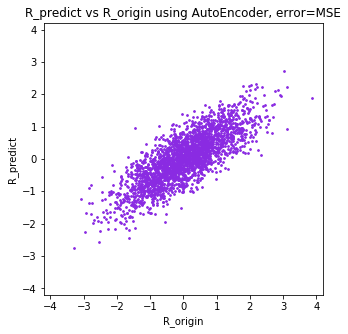

In [19]:
plt.figure(figsize=(5,5))
plt.scatter(R, R_MSE, s=3, c="blueviolet")
plt.xlabel("R_origin")
plt.xlim((-4.2, 4.2))
plt.ylabel("R_predict")
plt.ylim((-4.2, 4.2))
plt.title("R_predict vs R_origin using AutoEncoder, error=MSE")
plt.show()

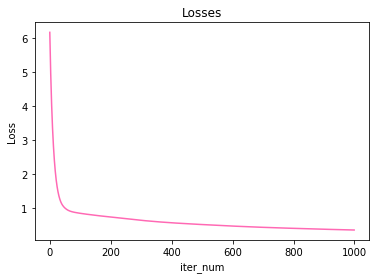

In [20]:
plt.plot(losses, c="hotpink")
plt.xlabel("iter_num")
plt.ylabel("Loss")
plt.title("Losses")
plt.show()

### Now we set N = 1 and T = 1000 to see how AutoEncoder works within long time range.

In [11]:
class AutoEncoder:
    def __init__(self,n_input,n_output =1,hidden_layers=[25,15,10],regress_layer_shape = [10,10],\
                 l=0,learning_rate=0.01,activation_X=tf.nn.relu,activation_Y = tf.nn.sigmoid, optimizer = tf.train.AdamOptimizer):
        self.X = tf.placeholder("float", [None, n_input])
        self.Y = tf.placeholder("float", [None, n_output])
        
        self.hidden_layers = hidden_layers
        self.regress_layer_shape = regress_layer_shape
        
        # activation_X is for Auto-encoder part
        # activation_Y is for predicting returns
        self.activation = activation_X
        
        self.weight_encoder = [0] * 3
        self.weight_decoder = [0] * 3
        self.bias_encoder = [0] * 3
        self.bias_decoder = [0] * 3
        
        # define encoder weights
        self.weight_encoder[0] = tf.Variable(tf.random_normal([n_input, hidden_layers[0]]))
        self.weight_encoder[1] = tf.Variable(tf.random_normal([hidden_layers[0], hidden_layers[1]]))
        self.weight_encoder[2] = tf.Variable(tf.random_normal([hidden_layers[1], hidden_layers[2]]))
        
        # define decoder weights
        self.weight_decoder[0] = tf.Variable(tf.random_normal([hidden_layers[2], hidden_layers[1]]))
        self.weight_decoder[1] = tf.Variable(tf.random_normal([hidden_layers[1], hidden_layers[0]]))
        self.weight_decoder[2] = tf.Variable(tf.random_normal([hidden_layers[0], n_input]))
        
        # define bias_encoder
        self.bias_encoder[0] = tf.Variable(tf.random_normal([hidden_layers[0]]))
        self.bias_encoder[1] = tf.Variable(tf.random_normal([hidden_layers[1]]))
        self.bias_encoder[2] = tf.Variable(tf.random_normal([hidden_layers[2]]))
        
        # define bias_decoder
        self.bias_decoder[0] = tf.Variable(tf.random_normal([hidden_layers[1]]))
        self.bias_decoder[1] = tf.Variable(tf.random_normal([hidden_layers[0]]))
        self.bias_decoder[2] = tf.Variable(tf.random_normal([n_input]))
        
        # define encoder_optimazer
        encoder_op = self.encoder()
        self.y_predict = self.predict(encoder_op, hidden_layers[-1], n_output, activation_Y)
        decoder_op = self.decoder(encoder_op)
        
        self.x_predict = decoder_op
        self.x_true = self.X
        
        # mean square error loss
        self.loss_X = tf.reduce_mean(tf.square(self.x_true - self.x_predict)) 
        self.loss_Y = tf.reduce_mean(tf.square(self.Y - self.y_predict))
        
        # we have a L1 regulariation for all the weight
        self.weight_encoder = np.array(self.weight_encoder)
        self.weight_decoder = np.array(self.weight_decoder)
        penalty = tf.constant(0.02)
        for i in range(len(self.weight_encoder)):
            penalty =tf.add(penalty, tf.reduce_mean(tf.abs(self.weight_encoder[i])))
            penalty = tf.add(penalty, tf.reduce_mean(tf.abs(self.weight_decoder[i])))
        self.penalty = tf.reduce_mean(penalty)
        self.loss_X = tf.add(self.loss_X, l * self.penalty)
        self.loss = tf.add(self.loss_X, self.loss_Y)
        #loss of predictions, which is equal to the loss of autoencoder part and neural network part.
        self.optimizer =  optimizer(learning_rate).minimize(self.loss)
        
    def encoder(self):
        layer = self.activation(tf.add(tf.matmul(self.X, self.weight_encoder[0]),self.bias_encoder[0]))
        layer = self.activation(tf.add(tf.matmul(layer, self.weight_encoder[1]),self.bias_encoder[1]))
        layer = self.activation(tf.add(tf.matmul(layer, self.weight_encoder[2]),self.bias_encoder[2]))
        return layer
    
    def decoder(self,Y):
        layer = self.activation(tf.add(tf.matmul(Y, self.weight_decoder[0]),self.bias_decoder[0]))
        layer = self.activation(tf.add(tf.matmul(layer, self.weight_decoder[1]),self.bias_decoder[1]))
        layer = self.activation(tf.add(tf.matmul(layer, self.weight_decoder[2]),self.bias_decoder[2]))
        return layer
    
    # define function "predict" to predict Y using encoder_op, which is the deepest inner layer
    def predict(self,X,n_input,n_output,activation):
        previous_layer_output = X
        previous_layer_size = n_input
        regress_layer_shape_full = self.regress_layer_shape + [n_output]
        # define all layers
        for i in range(0, len(regress_layer_shape_full)):
            if i < (len(regress_layer_shape_full) - 1):
                # inner (hidden) layer
                hidden_layer = core_layers.Dense(regress_layer_shape_full[i], activation=activation)   
            else:
                # output layer
                hidden_layer = core_layers.Dense(regress_layer_shape_full[i])
            hidden_layer.build([None, previous_layer_size])
            # output of a hidden layer is an iput to the next layer
            previous_layer_output = hidden_layer(previous_layer_output)
            
            # also redefine the size of the previous layer as the size of the current layer 
            previous_layer_size = regress_layer_shape_full[i]
        return previous_layer_output

In [12]:
reset_graph()
N=1
T=1000
p=50
b=0.5

class syn_data2:
    def __init__(self, b, p, N, T):
        A = np.eye(N)
        B = np.zeros((T,T))
        F = np.zeros((p,T))
        L = np.zeros((p,N))
        for s in range(T):
            for t in range(T):
                B[s,t]=b**(np.abs(s-t))
        noise = np.random.normal(size = (N,T))
        U=A.dot(noise.dot(sqrtm(B))).T
        F[0] = np.random.normal(size=T)
        L[0] = np.random.normal(size=N)
        self.F = F.T
        self.R = self.F.dot(L) + U

data = syn_data2(b, p ,N, T)
R = data.R
F = data.F

In [13]:
n_train = int(T*3/4)
F_train = F[:n_train]
R_train = R[:n_train]
F_test = F[n_train:]
R_test = R[n_train:]
print(F_train.shape, " ", R_train.shape)
print(F_test.shape, " ", R_test.shape)

(750, 50)   (750, 1)
(250, 50)   (250, 1)


In [14]:
model_auto = AutoEncoder(n_input=p,n_output=N,learning_rate=0.01)  

In [15]:
losses_AE = []
starttime = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(5000):
        _ = sess.run(model_auto.optimizer,feed_dict={model_auto.X:F_train,model_auto.Y:R_train})
        loss = sess.run(model_auto.loss,feed_dict={model_auto.X:F_train,model_auto.Y:R_train})
        output = sess.run(model_auto.y_predict,feed_dict={model_auto.X:F_train,model_auto.Y:R_train})
        losses_AE.append(loss)
    R_predict = sess.run(model_auto.y_predict,feed_dict={model_auto.X:F_test})
endtime = time.time()
print(loss)
print('Computational time:', endtime - starttime, 'seconds')

0.9171497
Computational time: 34.26392483711243 seconds


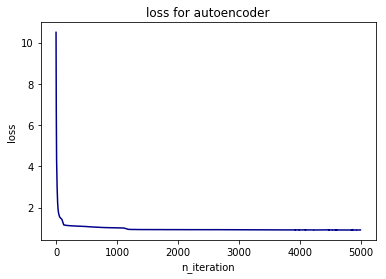

In [24]:
plt.plot(losses_AE[10:], c="darkblue")
plt.xlabel("n_iteration")
plt.ylabel("loss")
plt.title("loss for autoencoder")
plt.show()

In [25]:
error_auto =  np.average((R_test-R_predict)**2)
error_auto

1.0123584884270895

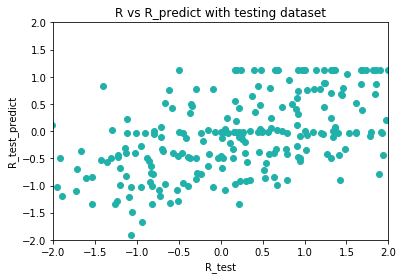

In [27]:
plt.scatter(R_test,R_predict, c="lightseagreen")
plt.xlabel("R_test")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.ylabel("R_test_predict")
plt.title('R vs R_predict with testing dataset')
plt.show()

# 3. Do the analysis with the S&P 500 data.
We downloaded S&P 500 data with Yahoo Finance and retrieve data with Pandas.DataFrame structure.

We add technical indicators as additional predictors. Talib is employed here in order to easily obtain these indicators.

In [31]:
sp = pd.read_csv("S&P500.csv")
sp.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-04-01,1326.410034,1370.180054,1326.410034,1370.180054,1370.180054,4745120000
1,2008-04-02,1369.959961,1377.949951,1361.550049,1367.530029,1367.530029,4320440000
2,2008-04-03,1365.689941,1375.660034,1358.680054,1369.310059,1369.310059,3920100000
3,2008-04-04,1369.849976,1380.910034,1362.829956,1370.400024,1370.400024,3703100000
4,2008-04-07,1373.689941,1386.739990,1369.020020,1372.540039,1372.540039,3747780000


In [32]:
open = sp["Open"]
high = sp["High"]
low = sp["Low"]
close = sp["Close"]
adj_close = sp["Adj Close"]
volume = sp["Volume"]
R = np.diff(np.log(adj_close.values))

In [28]:
# Creating Momentum variables
sp["ADX"] = talib.ADX(high, low, close, timeperiod = 10)
sp['AROONDOWN'] = talib.AROON(high, low, timeperiod = 10)[0]
sp['AROONUP'] = talib.AROON(high, low,timeperiod = 10)[1]
sp["AROONOSC"] = talib.AROONOSC(high, low, timeperiod = 10)
sp["BOP"] = talib.BOP(open, high, low, close)
sp["CCI"] = talib.CCI(high, low, close, timeperiod = 10)
sp["CMO"] = talib.CMO(close, timeperiod = 10)
sp["MFI"] = talib.MFI(high, low, close, volume, timeperiod = 10)
sp["PPO"] = talib.PPO(close, fastperiod = 10, slowperiod = 20, matype=0)
sp["ROC"] = talib.ROC(close, timeperiod = 10)
sp["RSI"] = talib.RSI(close, timeperiod = 10)
sp["TRIX"] = talib.TRIX(close, timeperiod=10)
sp["ULTOSC"] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Creating Overlap variables
# sp["MAMA"] = talib.MAMA(close, fastlimit=0, slowlimit=0)[0]
sp["SAR"] = talib.SAR(high, low, maximum=3)
sp["TEMA"] = talib.TEMA(close, timeperiod = 10)
sp["TRIMA"] = talib.TRIMA(close, timeperiod = 10)
sp["WMA"] = talib.WMA(close, timeperiod=3)

# Creating Volume variables
sp["ADOSC"] = talib.ADOSC(high, low, close, volume, fastperiod=5, slowperiod=10)
sp["OBV"] = talib.OBV(close, volume)

sp = sp.dropna(axis=0, how='any').dropna(axis=1, how='any').reset_index(drop=True)

defaulter = R
predictors =  sp.loc[:,(['ADX','AROONDOWN','AROONUP','CMO', 'CCI', 'MFI', 'PPO', 'RSI', 'TRIX', 'ULTOSC', 
                         'SAR', 'TEMA', 'TRIMA', 'WMA', 'ADOSC','OBV'])]
validation_size = len(sp) // 8
train_size = validation_size * 5


print("Size of training dataset is " + str(train_size))

X_train = predictors.loc[:train_size]
Y_train = defaulter.loc[:train_size].values.flatten()
print(X_train.shape, " ", Y_train.shape)

X_test = predictors.loc[train_size:,:]
Y_test = defaulter.loc[train_size:].values.flatten()
print(X_test.shape, " ", Y_test.shape)

Size of training dataset is 2241
(2242, 16)   (2242,)
(249, 16)   (249,)


We now use SVM to uncover factors.